# Project overview
This project consists in developing a computer vision system for the visual inspection of motorcycle connecting rods.

The data that we have consists in a series of grayscale images that were acquired with the backlight technique that contain connecting rods.

The project consists in adressing and solving different tasks related to the inspection and acquisition of data from the connecting rods.

As first step, we need to import the libraries that we will use. We're going to use OpenCV library for the computer vision operations. OpenCV reads images as numpy arrays, so we will also need numpy.

We will also use Colab's Drive library to load images from Google Drive.

Finally, we will use matplotlib to plot images, Python's math library for mathematical calculations and operations and glob library to explore directories and files.

We then need to access our private Google Drive to load the .zip file containing the images to use. We will unzip this zip file in the */content/* folder of Colab to load images faster.

In [1]:
# import useful libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  print('Running on CoLab')

  # mount drive
  drive.mount('/content/drive')

  #unzip the file containing task images
  !unzip "/content/drive/MyDrive/images.zip" -d /content/

else:
  print('Not running on CoLab')
  #unzip the file containing task images
  !unzip "/images.zip"

Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/images.zip
replace /content/__MACOSX/._images? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: /content/__MACOSX/._images  
replace /content/images/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: /content/images/.DS_Store  
replace /content/__MACOSX/images/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/__MACOSX/images/._.DS_Store  
  inflating: /content/__MACOSX/images/._first_task  
  inflating: /content/__MACOSX/images/._second_task  
  inflating: /content/images/first_task/.DS_Store  
  inflating: /content/__MACOSX/images/first_task/._.DS_Store  
  inflating: /content/images/first_task/TESI21.BMP  
  inflating: /content/__MACOSX/images/first_task/._TESI21.BMP  
  inflating: /content/images/first_task/Tesi33.bmp  
  inflating: /content/__MACOSX/images/first_ta

We will now have a folder named *images* in the */content/* folder. This folder has the following directory structure:

```
images
    first_task
    second_task
        contact
        dirty
        distractors
```

Each leaf folder contains .BMP images corresponding to the task represented by the folder.

## First task 
The first task consists in extracting information about the connecting rods from these images. For each rod in each image, we have to extract:
- the *type* of the rod: rods can be of two types, type A rods, which have one hole, and type B rods, which have two holes
- the *position* and *orientation*
- the *length*, *width* and *width at the barycenter*
- for *each hole*, the position of the *center* and the *diameter* size

This first task requires the computation of such information only on images in which the connecting rods appear well placed and well separated, not having any contact point.

### Binarization of the images
The first subtask of the first task consists in binarizing the images. In order to work with these images, we need to binarize them such that we have only two pixel values, one corresponding to the foreground and one corresponding to the background.

In this case, we will use *1 for the foreground* and *0 for the background* in order to make operations easier, so the foreground will be white while the background will be black in the binarized images, differently from the original images where the foreground is black while the background is white.

First of all, let's open and plot the images of this first task in order to get an overview. Let's first define a function to plot a list of images.

In [2]:
# define function to plot array of images
def plot_images(images: list, size: int = 30, cmap: str = "gray", vmin: int = -1, vmax: int = -1) -> None:
  fig = plt.figure(figsize=(size, size))
  rows = len(images)
  columns = 1
  for i in range(1, columns*rows + 1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    if vmin == -1:
      _vmin = np.min(img)
    else:
      _vmin = vmin
    if vmax == -1:
      _vmax = np.max(img)
    else:
      _vmax = vmax
    plt.imshow(img, cmap=cmap, vmin=_vmin, vmax=_vmax)
    plt.axis('off')
  plt.show()

Then, let's open all the images in the folder of the first task and let's plot them.

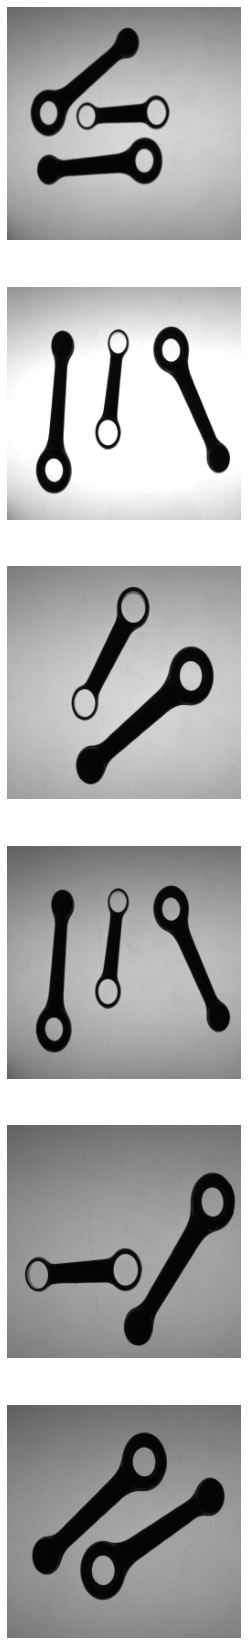

In [3]:
# open all the BMP images in the folder corresponding to the first task
files = glob.glob('images/first_task/*.BMP') + glob.glob('images/first_task/*.bmp') 
image_arrays = []

# for each image in the folder
for image_file in files:
  # open the image file and append the corresponding numpy array to the list of image array
  image_arrays.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))

# plot the images using the previously defined function
plot_images(image_arrays, vmin=0, vmax=255)

As we can see, the images present different lightning conditions: some are more bright than others, thus we will have different histogram distributions. For this reason, we cannot set a single threshold in common for all the images, we need to set a different threshold for each image, an adaptive one.

Let's first explore the grey-level histograms.

Min pixel value: 2
Max pixel value: 219


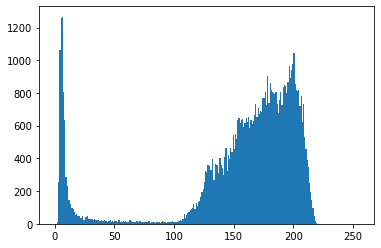

Min pixel value: 4
Max pixel value: 255


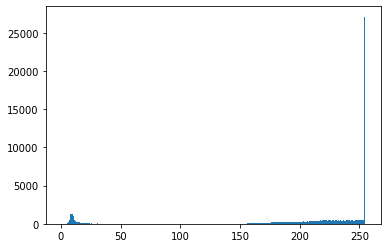

Min pixel value: 3
Max pixel value: 221


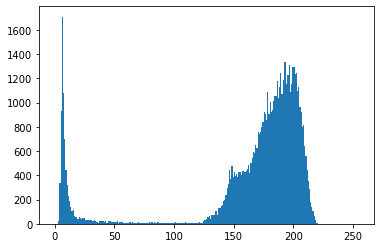

Min pixel value: 3
Max pixel value: 199


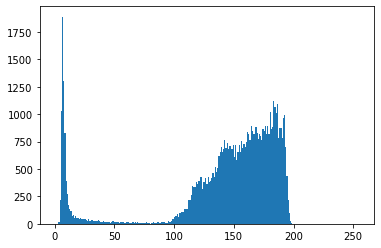

Min pixel value: 2
Max pixel value: 173


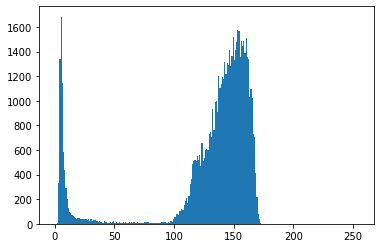

Min pixel value: 2
Max pixel value: 172


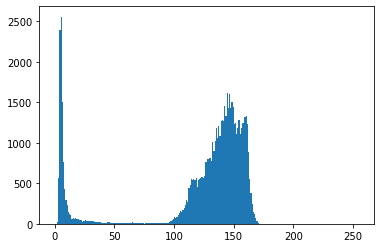

In [4]:
# for each image
for image in image_arrays:
  # print the range of pixel values
  print(f"Min pixel value: {np.min(image)}")
  print(f"Max pixel value: {np.max(image)}")

  # compute the histogram of the gray levels and plot it
  plt.hist(image.ravel(), 255, [0, 255])
  plt.show()

We can see that each image has a different distribution of pixel values, but every distribution is clearly bimodal. This means that the distribution of greyscale values is not uniform in each image, but instead we can see that for each image two clear spikes appear, however they do not appear always on the same greyscale values. Moreover, since we have to assume that we will have in a future images that will not respect this threshold, we have to use an adaptive threshold, and to binarize images we can thus use Otsu's algorithm.

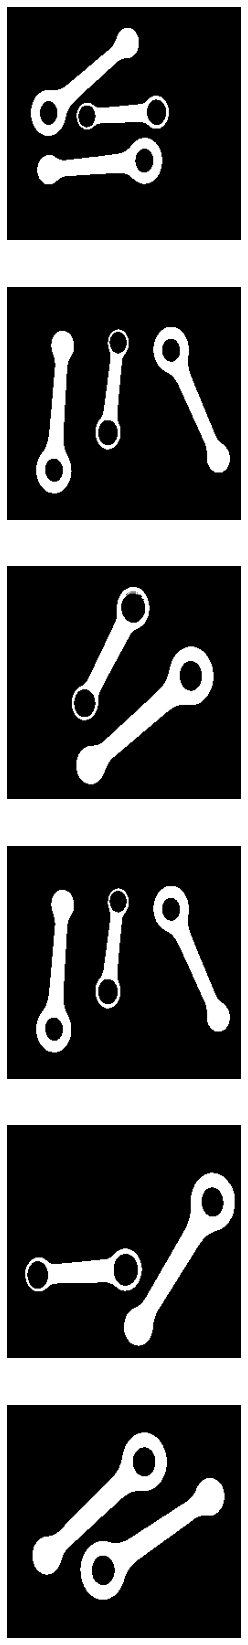

In [5]:
binarized_images = []

# for each image
for img in image_arrays:
  # make a copy of the current image
  copy_image = np.copy(img)

  # binarize the copied image
  _, copy_image = cv2.threshold(copy_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  copy_image = cv2.bitwise_not(copy_image) / 255

  # append to the list of binarized images
  binarized_images.append(copy_image)

plot_images(binarized_images)

We can see that Otsu's algorithm successfully binarized the image simply because the thresholding is automatic.

Let's now create a function that, given a list of images, returns the binarized images. We will use Otsu's algorithm to binarize the images, but before that we will apply a kernel to blur the image, so as to smooth the edges by removing any irregularities, and we will use this function later.

In [6]:
def binarize(images: list, kernel: str=None, kernel_size: int=5) -> list:
  binarized_images = []
  # for each image in the input list
  for image in images:
    # blur the image applying the chosen kernel, if any
    if kernel == "gaussian":
      # apply gaussian blur
      smoothed = cv2.GaussianBlur(np.copy(image), (kernel_size, kernel_size), 0)
    elif kernel == "median":
      # apply median blur
      smoothed = cv2.medianBlur(np.copy(image), kernel_size)
      smoothed = cv2.medianBlur(smoothed, kernel_size)
      smoothed = cv2.medianBlur(smoothed, kernel_size)
      smoothed = cv2.medianBlur(smoothed, kernel_size)
    else:
      smoothed = image
    
    # once smoothed, binarize the image
    _, binarized = cv2.threshold(np.copy(smoothed), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binarized = cv2.bitwise_not(binarized) / 255
    binarized_images.append(np.uint8(binarized))

  return binarized_images

### Finding instances
The next subtask of the task 1 is to find all the instances in each image.

In fact, for each instance in each image, we have to determine the type of the instance, the width and height, the width at the barycenter, the position and orientation and for each hole of the instance, the position of the center and the diameter size.

Before doing all of this, however, we need to find the instances of each image.

To do this, we can run a connected component labeling using OpenCV function connectedComponents which will find all the instances on the binarized images.

Let's get one of the binarized images to then find the instances in that image.

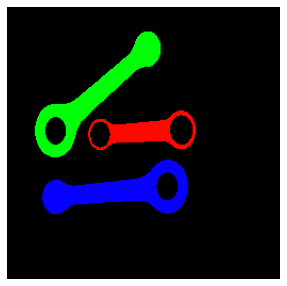

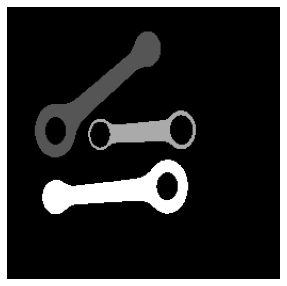

In [7]:
# define a function to create RGB labels for all the instances
def generate_rgb_labels(image_labels: list) -> list:
  rgb_labels = []
  for labels in image_labels:
    # map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    rgb_labels.append(labeled_img)
  
  return rgb_labels

# extact a binarized image
image = np.copy(binarized_images[0])

# execute connected components labeling
num_labels, labels = cv2.connectedComponents(np.uint8(image))

# generate RGB labelled images
rgb_labels = generate_rgb_labels([labels])

# plot the RGB instances
plot_images(rgb_labels, size=5)

# plot the greyscale instances
plot_images([labels], size=5)

We can clearly see each instance having a different color, meaning that each instance has been labeled and found successfully. In the second image, instead, we can see the output of the connected component labeling.

Now that we have all the instances, we can compute all the informations we need for each instance. Let's define a function to extract all the informations that we need from an instance.

So let's extract only one by one the instances from the previous image.

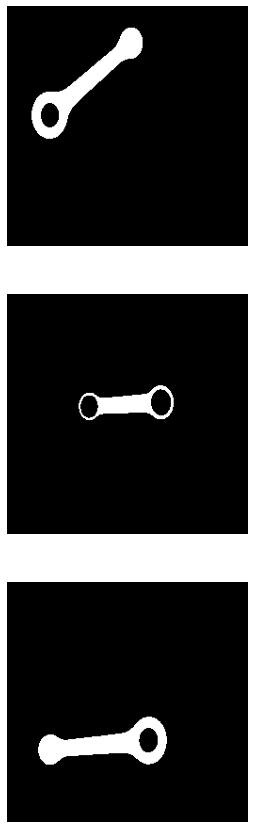

In [8]:
# extract the all the instances from the previous image
instances = []

# for each instance in the image
for i in range(1, num_labels):
  # extract the current image
  current_instance = np.uint8(np.copy(labels))
  current_instance[current_instance < i] = 0
  current_instance[current_instance > i] = 0

  # append the current instance to the list of instances
  instances.append(current_instance)

# plot all the extracted instances
plot_images(instances, size = 15)

### Type of the instance
First information that we need to compute is the type of the instance. A rod is of type A if it has only one hole, of type B if it has instead two holes.

An approach to do this to find the contours of the instance by using OpenCV function **findContours**. Once we have found the contours, we can simply count the number of child contours of the outermost contour (i.e. the rod). In fact **findContours** allows you to retrieve all of the contours and reconstructs a full hierarchy of nested contours using the parameter **cv2.RETR_TREE**.

Let's first extract one instance of the image and extract the contours of that instance.

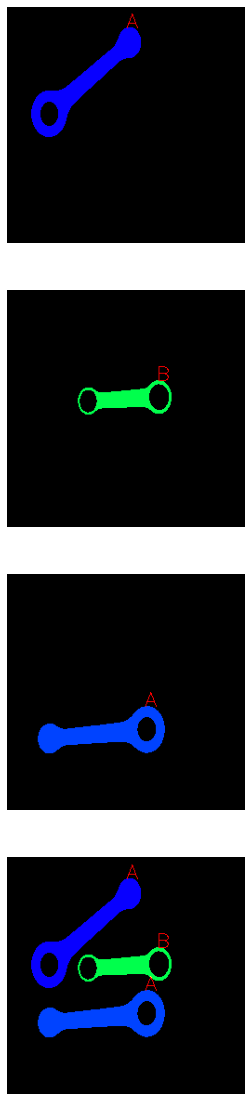

In [9]:
instances_with_type = []
for instance in instances:
  instance = instance.copy()

  # Get contours and respective hierarchy
  contours, hierarchy  = cv2.findContours(instance, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  hierarchy = np.squeeze(hierarchy)
  
  for contour_idx in range(hierarchy.shape[0]):
    # Check if the contour is one of the outermost contours (i.e. the rods)
    if hierarchy[contour_idx][-1] == -1:

      child = []
      num_child = 0
      for i in range(hierarchy.shape[0]):
        # Check if the the contour is a child of the instance
        if hierarchy[i][-1] == contour_idx:
          num_child += 1

      if num_child == 1:
        rod_type = "A"
      else:
        rod_type = "B"
      
      #Print type of rods
      font                   = cv2.FONT_HERSHEY_SIMPLEX
      bottomLeftCornerOfText = (contours[contour_idx][0][0][0], contours[contour_idx][0][0][1])
      fontScale              = 0.7
      fontColor              = (255, 0, 0)
      thickness              = 1
      lineType               = 3

      img = generate_rgb_labels([instance])[0]

      cv2.putText(img,rod_type, 
          bottomLeftCornerOfText, 
          font, 
          fontScale,
          fontColor,
          thickness,
          lineType)
      
      instances_with_type.append(img)

# Merge  all instances into one image
img = instances_with_type[0].copy()
for i in range(1, len(instances_with_type)):
  img = cv2.addWeighted(instances_with_type[i], 1, img, 1, 0) 

instances_with_type.append(img)

plot_images(instances_with_type, size=20,  vmin = 0, vmax = 255)

We can see that all instances are correctly classified for this input.

### Position, width, height and orientation
We now need to find the position of the instance in the image and the orientation of the rod (the angle with respect to the x axis). 

To find the position, we can compute the centroid of the instance and consider it as a position.

OpenCV provides a function **cv2.minAreaRect()** for finding the minimum area rotated rectangle. This takes as input a 2D point set, in our case the instance's contour, and returns a Box2D structure which contains all the details we need: center(x, y); (width, height); angle of rotation.

----- Instance: 1 -----
Width:  43.81
Height:  152.07
Angle:  45
----- Instance: 2 -----
Width:  35.09
Height:  100.13
Angle:  0
----- Instance: 3 -----
Width:  50.0
Height:  136.0
Angle:  0


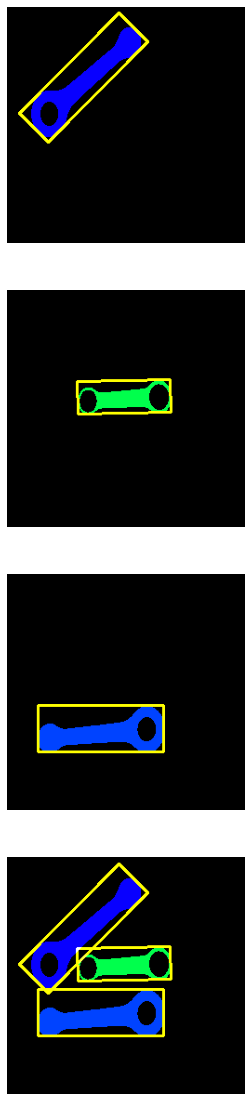

In [10]:
instances_feature = []
counter = 1
for instance in instances:
  instance = instance.copy()

  # Get contours and respective hierarchy
  contours, hierarchy  = cv2.findContours(instance, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  hierarchy = np.squeeze(hierarchy)
  for contour_idx in range(hierarchy.shape[0]):
    # Check if the contour is one of the outermost contours (i.e. the rods)
    if hierarchy[contour_idx][-1] == -1:

      # Find the minimum area rotated rectangle
      rect = cv2.minAreaRect(contours[contour_idx])

      center= (int(rect[0][0]),int(rect[0][1]))
      width= int(rect[1][0])
      height= int(rect[1][1])
      angle= int(rect[2])

      # Check that the connecting rod height is the largest measurement and map the angle in (0, 180) degrees
      if width < height:
        angle = 90 - angle
      else:
        height = rect[1][0]
        width = rect[1][1]
        angle = -angle

      box = cv2.boxPoints(rect)
      box = np.int0(box) # coords from left-bottom corner clockwise

      print("----- Instance: "+str(counter)+" -----")

      print("Width: ", round(width, 2))
      print("Height: ", round(height, 2))
      print("Angle: ", round(angle, 2))

      counter +=1

      #Print instance as rgb image
      img = generate_rgb_labels([instance])[0]

      #Print object box
      cv2.drawContours(img, [box],0,(255,255,0),2)

      instances_feature.append(img)

# Merge  all instances into one image
img = instances_feature[0].copy()
for i in range(1, len(instances_feature)):
  img = cv2.addWeighted(instances_feature[i], 1, img, 1, 0) 

instances_feature.append(img)

plot_images(instances_feature, size=20)

By checking the prints and images we can see that this method returns all the values requested by us without any kind of problem

### Width at the barycenter.

For the calculation of the width at the
barycenter, we have chosen instead to calculate the two points, lying on the contour of the connecting rod component which intersect the minor axis of the object.

Once these are found, the width is trivially calculated using the Pythagorean theorem for the distance between two points on a plane.

In [11]:
def get_width_at_barycenter(img: np.array, obj_contour: list, center_mass: tuple) -> list:

  contours, _  = cv2.findContours(img, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

  rows,cols = img.shape[:2]
  # Define major axis
  [vx,vy,x,y] = cv2.fitLine(contours[obj_contour], cv2.DIST_L2,0,0.01,0.01)
  lefty = int((-x*vy/vx) + y)
  righty = int(((cols-x)*vy/vx)+y)

  major_axis = np.array([vx, vy])

  # Rotation Matrix
  theta = math.radians(90)
  rot_matrix = np.array([[math.cos(theta), -math.sin(theta)],
                        [math.sin(theta), math.cos(theta)]])
  
  # Matrix multiplication
  minor_axis = (rot_matrix @ major_axis)
  vx_minor = minor_axis[0][0]
  vy_minor = minor_axis[1][0]
  minor_axis = np.array([vx_minor, vy_minor])

  center_x = center_mass[0]
  center_y = center_mass[1]

  lefty = int((-center_x*vy_minor/vx_minor) + center_y)
  righty = int(((cols-center_x)*vy_minor/vx_minor)+center_y)

  # Define instance's contour
  contour = np.zeros(img.shape)
  contour = cv2.drawContours(contour, contours, obj_contour, 1, 1)

  # Define line on which the minor axis lies 
  line = np.zeros(img.shape)
  line = cv2.line(line,(cols-1,righty),(0,lefty),1,1, lineType = cv2.LINE_4)

  # Find intersection between contour and line
  points_at_barycenter = np.logical_and(contour, line)
  points_at_barycenter_index = np.where(points_at_barycenter)

  points_at_barycenter_x = points_at_barycenter_index[1]
  points_at_barycenter_y = points_at_barycenter_index[0]

  #Define width and points through which the segment passes
  width_center_points = [(points_at_barycenter_x[0], points_at_barycenter_y[0]), (points_at_barycenter_x[-1], points_at_barycenter_y[-1])]
  width_at_barycenter = round(math.sqrt((points_at_barycenter_x[0] - points_at_barycenter_x[-1])**2 + (points_at_barycenter_y[0] - points_at_barycenter_y[-1])**2))

  return [width_center_points, width_at_barycenter]

----- Instance: 1 -----
width_at_barycenter:  17
----- Instance: 2 -----
width_at_barycenter:  17
----- Instance: 3 -----
width_at_barycenter:  19


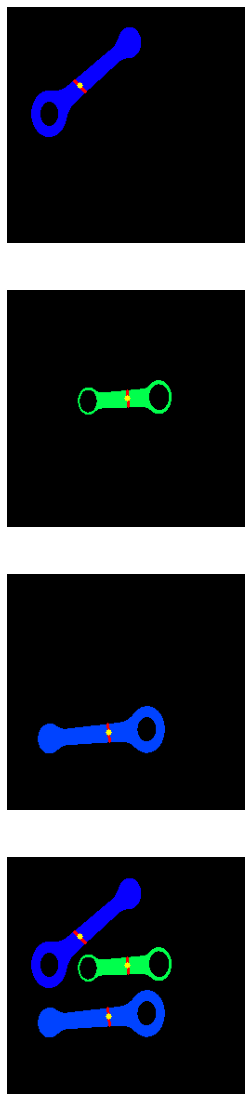

In [12]:
instances_center = []
counter = 1
for instance in instances:
  instance = instance.copy()

  #Get contours and respective hierarchy
  contours, hierarchy  = cv2.findContours(instance, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  hierarchy = np.squeeze(hierarchy)
  for contour_idx in range(hierarchy.shape[0]):
    # Check if the contour is one of the outermost contours (i.e. the rods)
    if hierarchy[contour_idx][-1] == -1:

      # Center of mass
      M = cv2.moments(contours[contour_idx])
      if M['m00'] != 0:
          center_x = int(M['m10']/M['m00'])
          center_y = int(M['m01']/M['m00'])
          center_mass = (center_x, center_y)
      # Width at the barycenter
      width_center_points, width_at_barycenter = get_width_at_barycenter(instance, contour_idx, center_mass)

      box = cv2.boxPoints(rect)
      box = np.int0(box) # coords from left-bottom corner clockwise

      print("----- Instance: "+str(counter)+" -----")

      print("width_at_barycenter: ", round(width_at_barycenter, 2))

      counter +=1

      #Print instance as rgb image
      img = generate_rgb_labels([instance])[0]
      #Print Width at the barycenter
      cv2.line(img, width_center_points[0], width_center_points[1], (255, 0, 0), 2)
      #Print center of mass
      cv2.circle(img, center_mass, 3, (255, 255, 0), -1)

      instances_center.append(img)

# Merge  all instances into one image
img = instances_center[0].copy()
for i in range(1, len(instances_center)):
  img = cv2.addWeighted(instances_center[i], 1, img, 1, 0) 

instances_center.append(img)

plot_images(instances_center, size=20)

As we can see, this approach allowed us to calculate the width at the position of the center mass correctly for each instance of the image taken into consideration

### Position of the center and diameter size for each hole

The required information also includes the diameter and the position of the center of the connecting rod holes. The approach adopted was based on defining the presence of the hole through the use of findCountours (same approach used for the labeling of the connecting rods) and calculating the bounding box on this with the method cv2.boundingRect, which returns the position of the vertex left-bottom, height and width: values by which it is possible to trivially calculate the center and diameter of the hole. (d = (w + h) / 2; c = (x + w) / 2, (y + h) / 2)

----- Instance: 1 -----
center:  (45, 116)
diameter:  24.5
----- Instance: 2 -----
center:  (87, 120)
diameter:  23.5
----- Instance: 3 -----
center:  (163, 115)
diameter:  26.5
----- Instance: 4 -----
center:  (150, 168)
diameter:  25.0


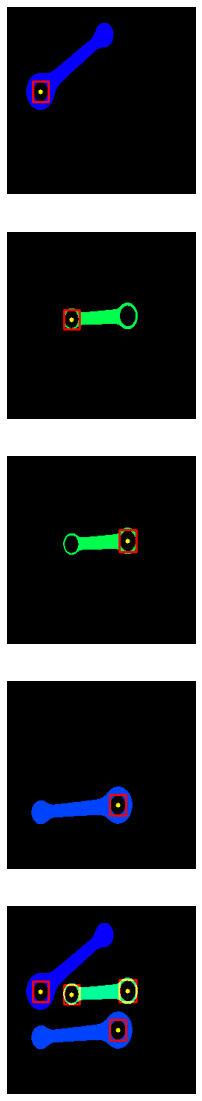

In [13]:
instances_holes = []
counter = 1
for instance in instances:
  instance = instance.copy()

  #Get contours and respective hierarchy
  contours, hierarchy  = cv2.findContours(instance, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  hierarchy = np.squeeze(hierarchy)
  for contour_idx in range(hierarchy.shape[0]):
    # Check if the contour is one of the outermost contours (i.e. the rods)
    if hierarchy[contour_idx][-1] == -1:

      child = []

      for i in range(hierarchy.shape[0]):
        # Check if there are children (i.e. the holes)
        if hierarchy[i][-1] == contour_idx:

          x,y,w,h = cv2.boundingRect(contours[i])

          # Define center and diameter of hole
          center = (int(x+w/2),int(y+h/2))
          diameter = (w + h) / 2

          print("----- Instance: "+str(counter)+" -----")

          print("center: ", center)
          print("diameter: ", diameter)

          counter +=1

          img = generate_rgb_labels([instance])[0]

          #Print center of the hole
          cv2.circle(img, center, 3, (255, 255, 0), -1)
          #Print rectangle around the hole
          cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

          instances_holes.append(img)
          
# Merge  all instances into one image
img = instances_holes[0].copy()
for i in range(1, len(instances_holes)):
  img = cv2.addWeighted(instances_holes[i], 1, img, 1, 0) 

instances_holes.append(img)

plot_images(instances_holes, size=20)

## Second task 
The second task consists in extracting the same informations such as in the first task, but now we have to deal with the following three changes in the characteristics of the working images: 
- Images may contain other objects (i.e. screws and washers) that need not to be analysed by the
system (such kind of objects are often referred to in computer vision as *“distractors”*).
-  Rods can have contact points but do not overlap one to another
- The inspection area may be dirty due to the presence of scattered iron powder.

So, this task consists in strengthening the system in order to correctly accept inputs with the above characteristics.

### Deal with distractors
One of the additional requirements of the second task is to manage the presence of
disturbance (such as screws and washers), which should not be analyzed by the system.
To meet this requirement, we have chosen to exploit, for each object, the following approaches sequentially:


1.   Check that the instance contour is the outermost one in the contours hierarchy, so as to avoid unintentionally classifying child contours
2.   Check that the instance has at least one hole and no more than two, characteristics which by definition belong to the connecting rods
3.   Calculate the ratio between *perimeter^2/area* (known as compactness or Form Factor) and define min/max threshold in which this value identifies a connecting rod object

In this way we are able to deal with screws that are close to the shape of the connecting rods, but without having their own characteristics such as the holes at the ends, and at the same time deal with washers that have holes, but which by their nature have a form factor incompatible with that of the connecting rods.

First of all, let's open and plot the images of this first task in order to get an overview.

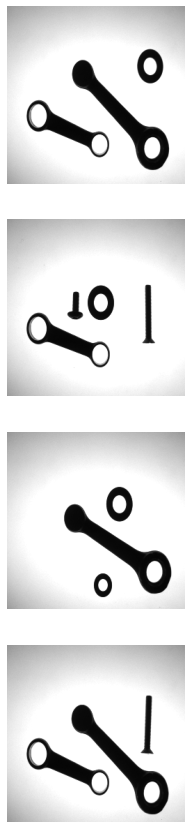

In [14]:
# open all the BMP images in the folder corresponding to the distractors task
files = glob.glob('images/second_task/distractors/*.BMP')
image_distractors = []

# for each image in the folder
for image_file in files:
  # open the image file and append the corresponding numpy array to the list of image array
  image_distractors.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))

# plot the images using the previously defined function
plot_images(image_distractors, size=15, vmin=0, vmax=255)

To define the boundaries of Compactness (form factor) for a connecting rod we can simply analyze the instances from images that do not have distractors of any kind to extract the area and perimeter and calculate the Compactness factor of each occurrence. Once this is done, simply compare the various values and take the maximum and minimum as boundaries.

This process is possible since we have already ascertained that our system is robust for input with only target objects and without distractors or noise of any kind.

In [15]:
areas = []
perimeters = []
C_list = []
proportion = []
for img in image_arrays:
  img = binarize([img], True)[0]
  contours, hierarchy  = cv2.findContours(img, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  hierarchy = np.squeeze(hierarchy)
  for contour_idx in range(hierarchy.shape[0]):
    if hierarchy[contour_idx][-1] == -1:
      
      area = cv2.contourArea(contours[contour_idx])
      perimeter = cv2.arcLength(contours[contour_idx],True)
      C = perimeter**2/area

      areas.append(area)
      perimeters.append(perimeter)
      C_list.append(C)

LOWER_THR = min(C_list)
UPPER_THR = max(C_list)

In [16]:
LOWER_THR, UPPER_THR

(30.675014973251372, 48.7945323629217)


Once the thresholds have been found, all that remains is to implement the controls described above in the **is_distactor** function

In [17]:
def is_distractor(contours: list, hierarchy: list, contour_index: int, upper_thr: float = UPPER_THR, lower_thr: float = LOWER_THR) -> bool:

  # check if the object is a child
  if hierarchy[contour_index][-1] != -1:
    return True

  num_child = 0
  for i in range(hierarchy.shape[0]):
    if hierarchy[i][-1] == contour_index:
      num_child += 1

      if num_child > 2:
        return True
  
  if num_child == 0:
    return True

  area = cv2.contourArea(contours[contour_index])
  perimeter = cv2.arcLength(contours[contour_index],True)
  C = perimeter**2/area
  
  if C > upper_thr or C < lower_thr:
    return True

  return False

At this point we define a general function **get_objects_info** where it is possible, given an image, to analyze the objects present in it.
For each object instance, a check will be made whether it is a connecting rod or a distractor and then, if it is actually a connecting rod, its features will be extracted and saved in a specific data structure. These features will then be printed on the screen thanks to the **print_image_info** function

In [18]:
def get_objects_info(img: np.array) -> tuple:

  # execute connected components labeling
  num_labels, labels = cv2.connectedComponents(np.uint8(img)) 

  # extract the all the instances from the previous image
  instances = []

  # for each instance in the image
  for i in range(1, num_labels):
    # extract the current image
    current_instance = np.uint8(np.copy(labels))
    current_instance[current_instance < i] = 0
    current_instance[current_instance > i] = 0

    # append the current instance to the list of instances
    instances.append(current_instance)

  instances_feature = []
  instance_images = []

  for instance in instances:

    #Get contours and respective hierarchy
    contours, hierarchy  = cv2.findContours(instance, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    hierarchy = np.squeeze(hierarchy)

    if len(hierarchy.shape) == 1:
      hierarchy = np.expand_dims(hierarchy, 0)
    for contour_idx in range(hierarchy.shape[0]):

      if not is_distractor(contours, hierarchy, contour_idx):

        child = []
        num_child = 0
        for i in range(hierarchy.shape[0]):
          # Check if there are children (i.e. the holes)
          if hierarchy[i][-1] == contour_idx:
            num_child += 1

            x,y,w,h = cv2.boundingRect(contours[i])
            # Define center and diameter of hole
            center = (int(x+w/2),int(y+h/2))
            diameter = (w + h) / 2

            child.append({'center':center, 'diameter': diameter})

        if num_child == 1:
          rod_type = "A"
        else:
          rod_type = "B"

        
        area = cv2.contourArea(contours[contour_idx])
        perimeter = cv2.arcLength(contours[contour_idx],True)

        # Find the minimum area rotated rectangle
        rect = cv2.minAreaRect(contours[contour_idx])

        center= (int(rect[0][0]),int(rect[0][1]))
        width= int(rect[1][0])
        height= int(rect[1][1])
        angle= int(rect[2])

         # Check that the connecting rod height is the largest measurement and map the angle in (0, 180) degrees
        if width < height:
          angle = 90 - angle
        else:
          height = rect[1][0]
          width = rect[1][1]
          angle = -angle
          

        box = cv2.boxPoints(rect)
        box = np.int0(box) # coords from left-bottom corner clockwise

        # Center of mass
        M = cv2.moments(contours[contour_idx])
        if M['m00'] != 0:
            center_x = int(M['m10']/M['m00'])
            center_y = int(M['m01']/M['m00'])
            center_mass = (center_x, center_y)
        # Width at the barycenter
        width_center_points, width_at_barycenter = get_width_at_barycenter(instance, contour_idx, center_mass)

        # instance_img = generate_rgb_labels([instance])[0]
        instance_images.append(instance)


        # Fill the struct with the current instance information
        instances_feature.append({
            'perimeter': perimeter,
            'area': area,
            'box': box,
            'width': width,
            'height': height,
            'center_mass': center_mass,
            "width_center": width_at_barycenter,
            'width_center_points': width_center_points,
            'angle': angle,
            'rod_type': rod_type,
            'child': child
            })
        
  # Merge  all instances into one image
  img_feature = instance_images[0].copy()
  for i in range(1, len(instance_images)):
    img_feature = cv2.addWeighted(instance_images[i], 1, img_feature, 1, 0)

  return img_feature, instances_feature

def print_image_info(img: np.array) -> None:
  img = img.copy()
  img_holes = img.copy()

  img_feature, instances = get_objects_info(img)


  contours, hierarchy  = cv2.findContours(img_feature, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  hierarchy = np.squeeze(hierarchy)

  img_feature = generate_rgb_labels([img_feature])[0]


  #Print contours
  cv2.drawContours(img_feature, contours, -1, (255,255,255), 1)

  counter = 1
  for instance in instances:
    print("----- Instance: "+str(counter)+" -----")

    print("type: ", instance['rod_type'])
    print("Width: ", round(instance['width'],2))
    print("Height: ", round(instance['height'],2))
    print("Angle: ", round(instance['angle'],2))
    print("Width at barycenter: ", round(instance['width_center'],2))
    print("Perimeter: ", round(instance['perimeter'], 2))
    print("Area: ", round(instance['area'], 2))

    #Print Width at the barycenter
    cv2.line(img_feature, instance['width_center_points'][0], instance['width_center_points'][1], (255, 0, 255), 1)

    #Print center of mass
    cv2.circle(img_feature, instance['center_mass'], 3, (255, 0, 0), -1)

    print("Holes: ")
    for child in instance['child']:
      print("\tCenter: ", tuple(map(lambda x: isinstance(x, float) and round(x, 2) or x, child['center'])))
      print("\tDiameter: ", round(child['diameter'], 2))
      print()

      x = int(child['center'][0] - child['diameter']/2)
      y = int(child['center'][1] - child['diameter']/2)
      w = h = int(child['diameter'])
      cv2.circle(img_feature, (tuple(map(lambda x: isinstance(x, float) and int(x) or x, child['center']))), 1, (255, 0, 0), -1)
      cv2.rectangle(img_feature,(x,y),(x+w,y+h),(255,0,0),1)



    #Print object box
    cv2.drawContours(img_feature, [instance['box']],0,(0,0,255),1)

    p_x = instance['box'][np.argmin(instance['box'][:, 1])][0]
    p_y = instance['box'][np.argmin(instance['box'][:, 1])][1]
    #Print type of rods
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (p_x, p_y)
    fontScale              = 0.4
    fontColor              = (255,0,0)
    thickness              = 1
    lineType               = cv2.LINE_AA

    cv2.putText(img_feature,"ID"+str(counter)+":"+instance['rod_type'], 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        thickness,
        lineType)
    
    counter += 1
  print("-----------------------")

  plt.figure(figsize=(6, 6))
  plt.imshow(img_feature, cmap="viridis")

Now all that remains is to binarize an image among those containing distractors and use the result of this as input for the print function

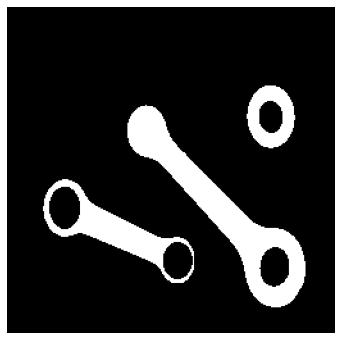

----- Instance: 1 -----
type:  A
Width:  53
Height:  192
Angle:  129
Width at barycenter:  21
Perimeter:  461.71
Area:  5345.5
Holes: 
	Center:  (208, 203)
	Diameter:  29.0

----- Instance: 2 -----
type:  B
Width:  42
Height:  128
Angle:  153
Width at barycenter:  21
Perimeter:  331.71
Area:  3317.0
Holes: 
	Center:  (133, 198)
	Diameter:  28.0

	Center:  (45, 157)
	Diameter:  30.5

-----------------------


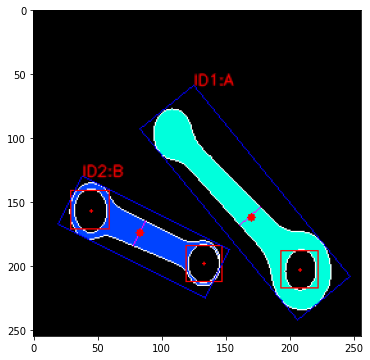

In [19]:
binarized_image_distractors = binarize(image_distractors, kernel="gaussian", kernel_size=7)
plot_images([binarized_image_distractors[0]], 6)
print_image_info(binarized_image_distractors[0])

### Deal with contact points between instances
A further requirement is constituted by the management of connecting rods in contact conditions, that is the objects that appear as if they were fused together, and thus a classification of instances based on the recognition of the contours is not applicable. Therefore in these conditions a separation is necessary for the purposes of a correct classification. To meet the requirement, it was therefore chosen to
adopt an approach based on the calculation of the convex hull of the components-connecting rods, and on the analysis of convexity defects.

Once the points of convexity defects have been found, just draw a black line on the binarized image to separate the two instances. Unfortunately, convexity defects are also detected on other points of the connecting rod contour, so it was decided to draw the line only between detected points that are below a certain distance threshold between them. This approach is possible, since given the shape of the connecting rods we can be sure that the possible contact points extend only for a few pixels.

Furthermore, to avoid false positives and unnecessary executions, it was decided to check the area, as that of 2 connected components will certainly be greater than that of only one, so as to carry out the process only on the most suspicious cases.


Again, let's open and plot the images of this first task in order to get an overview.

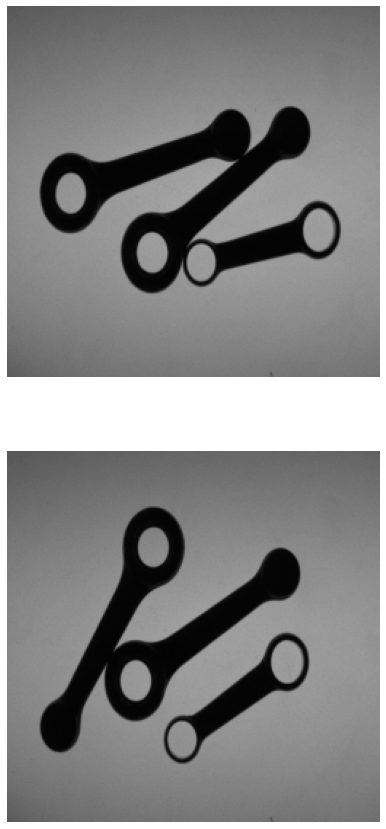

In [20]:
# open all the BMP images in the folder corresponding to the contact points task
files = glob.glob('images/second_task/contact/*.BMP')
image_contact = []

# for each image in the folder
for image_file in files:
  # open the image file and append the corresponding numpy array to the list of image array
  image_contact.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))

# plot the images using the previously defined function
plot_images(image_contact, size=15, vmin=0, vmax=255)

Here the definition of the **separate_instances** function

In [21]:
def separate_instances(images: list) -> list:
  separated_images = []
  for img in images:
    contours, _  = cv2.findContours(img, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for contour_idx in range(len(contours)):
      if cv2.contourArea(contours[contour_idx]) > 5999: # Max area rods
        contour = contours[contour_idx]
        
        contour = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)

        points = []

        for i in range(defects.shape[0]):
          _, _, index, _ = defects[i, 0]
          point = tuple(contour[index][0])
          points.append(point)

          for i in range(len(points)):
            for j in range(i+1, len(points)):
              distance = round(math.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2))
              # Maximum distance threshold
              if distance <= 40:
                # Draw the separation line
                cv2.line(img, points[i], points[j], (0, 0, 0), 1, lineType = cv2.LINE_4)
                

    separated_images.append(img)
  return separated_images

Now all that remains is to binarize the images among those containing contact components and use the results of this as input for the separate_instances function

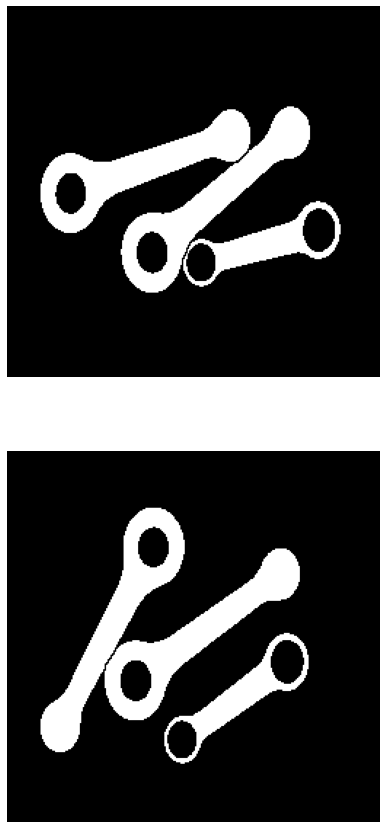

In [22]:
binarized_image_contact = binarize(image_contact)
separated_images = separate_instances(binarized_image_contact)
plot_images(separated_images, size=15)

As we can see the components have been separated correctly and now it is possible to analyze the instances without any problem

----- Instance: 1 -----
type:  A
Width:  48.08
Height:  164.76
Angle:  45
Width at barycenter:  19
Perimeter:  404.46
Area:  4179.5
Holes: 
	Center:  (99, 169)
	Diameter:  27.0

----- Instance: 2 -----
type:  A
Width:  52.44
Height:  152.7
Angle:  24
Width at barycenter:  21
Perimeter:  393.5
Area:  4174.0
Holes: 
	Center:  (43, 129)
	Diameter:  26.5

----- Instance: 3 -----
type:  B
Width:  38.3
Height:  111.63
Angle:  17
Width at barycenter:  20
Perimeter:  290.94
Area:  2583.0
Holes: 
	Center:  (133, 176)
	Diameter:  25.0

	Center:  (214, 154)
	Diameter:  28.0

-----------------------


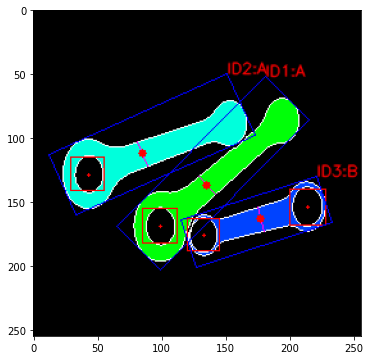

In [23]:
print_image_info(binarized_image_contact[0])

### Deal with dirty inspection area
The last requirement is the management of dirt (cattered iron powder) present in some images, which is responsible for causing a less clear distinction between the background and the objects of interest. The dirt of the powder, since it is very fine, introduces small dark areas of the size of a few pixels on the foreground, comparable to salt and pepper noise. It was therefore decided to negotiate
this noise by applying a filter times
median with a 3x3 kernel before the binarization step. Filtering
applied allowed to completely eliminate the powder, solving the
disturbance without altering the shape of the connecting rods.

The same result can also be obtained using a Gaussian filter with a 7x7 kernel before the binarization step

Both of these approaches have already been implemented in the binarize function, which was used to binarize the previous images as well

One last time, let's open and plot the images  in order to get an overview.

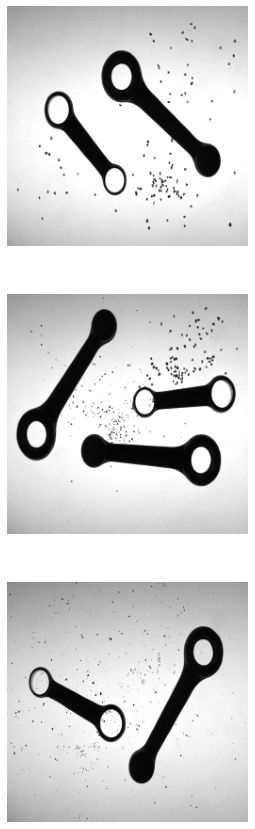

In [24]:
# open all the BMP images in the folder corresponding to the dirty points task
files = glob.glob('images/second_task/dirty/*.BMP')
image_dirty = []

# for each image in the folder
for image_file in files:
  # open the image file and append the corresponding numpy array to the list of image array
  image_dirty.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))

# plot the images using the previously defined function
plot_images(image_dirty, size=15, vmin=0, vmax=255)

Let's try to use the median filter

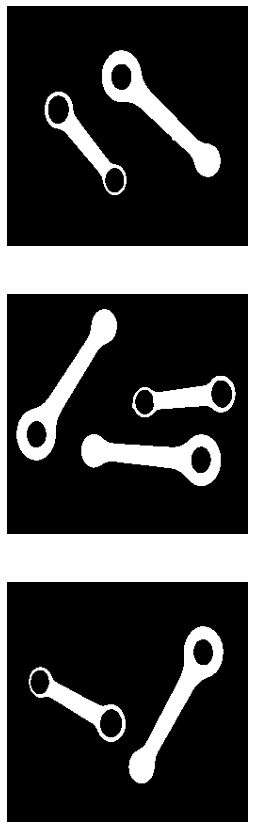

In [25]:
binarized_image_dirty_median = binarize(images=image_dirty, kernel="median", kernel_size=3)

plot_images(binarized_image_dirty_median, size=15)

Let's try to use the gaussian filter

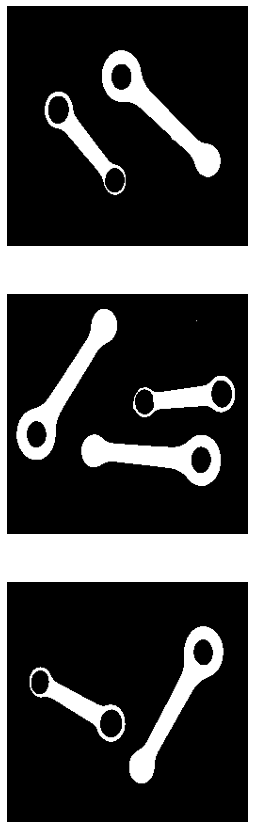

In [26]:
binarized_image_dirty_gaussian = binarize(images=image_dirty, kernel="gaussian", kernel_size=7)

plot_images(binarized_image_dirty_gaussian, size=15)

As we can see, both approaches work correctly and allow us to have a processed input to be fed to the function that extracts the features

----- Instance: 1 -----
type:  A
Width:  44.73
Height:  178.62
Angle:  61
Width at barycenter:  17
Perimeter:  428.66
Area:  4149.5
Holes: 
	Center:  (31, 149)
	Diameter:  26.5

----- Instance: 2 -----
type:  B
Width:  38.24
Height:  108.1
Angle:  3
Width at barycenter:  19
Perimeter:  280.07
Area:  2518.5
Holes: 
	Center:  (146, 114)
	Diameter:  25.5

	Center:  (228, 106)
	Diameter:  27.5

----- Instance: 3 -----
type:  A
Width:  53
Height:  147
Angle:  179
Width at barycenter:  21
Perimeter:  381.42
Area:  4126.0
Holes: 
	Center:  (206, 176)
	Diameter:  26.5

-----------------------


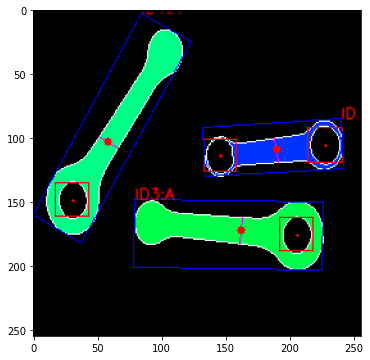

In [27]:
print_image_info(binarized_image_dirty_gaussian[1])

## Conclusions

All the required objects have been performed correctly and the developed system seems to behave well with the domain given for the test.

Below are the input and output printouts for all the samples made available for the project

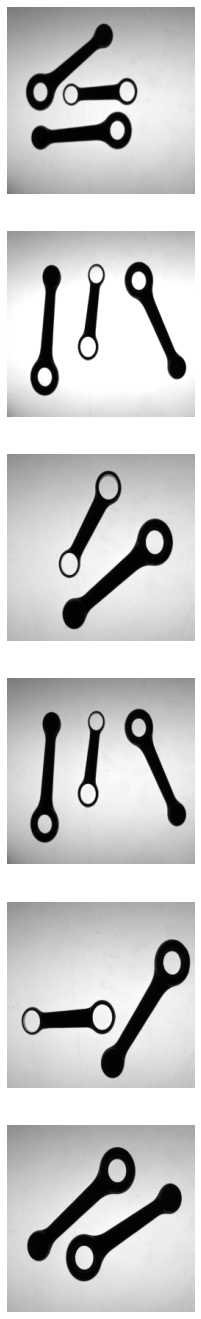

Image Number  1
----- Instance: 1 -----
type:  A
Width:  43.81
Height:  152.07
Angle:  45
Width at barycenter:  17
Perimeter:  369.0
Area:  3510.5
Holes: 
	Center:  (45, 116)
	Diameter:  24.5

----- Instance: 2 -----
type:  B
Width:  35.09
Height:  100.13
Angle:  0
Width at barycenter:  17
Perimeter:  258.51
Area:  2169.0
Holes: 
	Center:  (87, 120)
	Diameter:  23.5

	Center:  (163, 115)
	Diameter:  26.5

----- Instance: 3 -----
type:  A
Width:  50.0
Height:  136.0
Angle:  0
Width at barycenter:  19
Perimeter:  352.35
Area:  3515.5
Holes: 
	Center:  (150, 168)
	Diameter:  25.0

-----------------------
Image Number  2
----- Instance: 1 -----
type:  A
Width:  39
Height:  169
Angle:  110
Width at barycenter:  15
Perimeter:  402.58
Area:  3460.5
Holes: 
	Center:  (179, 69)
	Diameter:  24.0

----- Instance: 2 -----
type:  B
Width:  26.98
Height:  131.73
Angle:  84
Width at barycenter:  14
Perimeter:  304.75
Area:  2156.5
Holes: 
	Center:  (110, 159)
	Diameter:  26.0

	Center:  (121, 61)
	Di

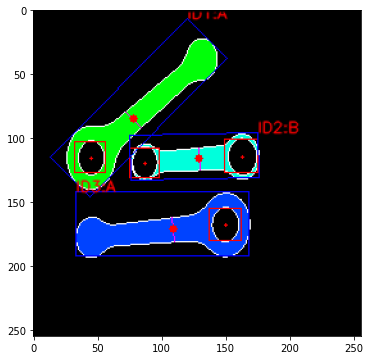

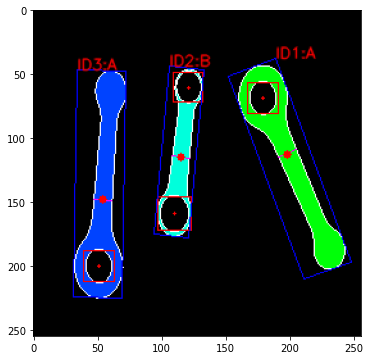

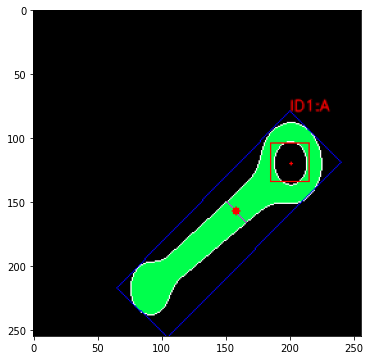

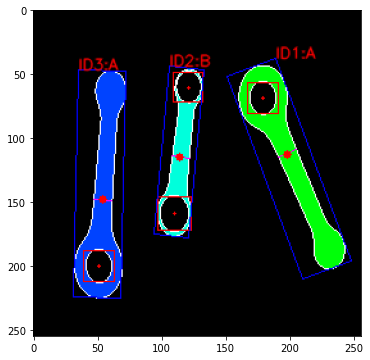

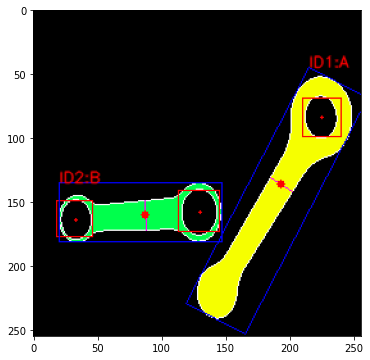

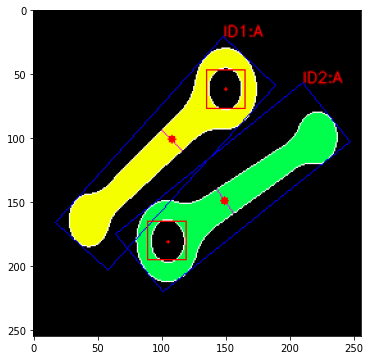

In [28]:
plot_images(image_arrays, size=24)

for i in range(len(binarized_images)):
  print("Image Number ", i+1)
  print_image_info(binarized_images[i])

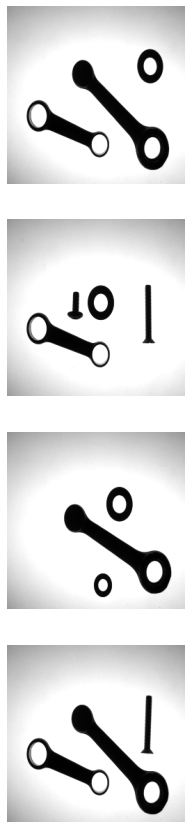

Image Number  1
----- Instance: 1 -----
type:  A
Width:  53
Height:  192
Angle:  129
Width at barycenter:  21
Perimeter:  461.71
Area:  5345.5
Holes: 
	Center:  (208, 203)
	Diameter:  29.0

----- Instance: 2 -----
type:  B
Width:  42
Height:  128
Angle:  153
Width at barycenter:  21
Perimeter:  331.71
Area:  3317.0
Holes: 
	Center:  (133, 198)
	Diameter:  28.0

	Center:  (45, 157)
	Diameter:  30.5

-----------------------
Image Number  2
----- Instance: 1 -----
type:  B
Width:  43
Height:  128
Angle:  154
Width at barycenter:  22
Perimeter:  332.29
Area:  3360.5
Holes: 
	Center:  (134, 195)
	Diameter:  27.5

	Center:  (45, 158)
	Diameter:  30.5

-----------------------
Image Number  3
----- Instance: 1 -----
type:  A
Width:  56
Height:  182
Angle:  141
Width at barycenter:  22
Perimeter:  452.7
Area:  5325.0
Holes: 
	Center:  (212, 201)
	Diameter:  29.0

-----------------------
Image Number  4
----- Instance: 1 -----
type:  A
Width:  53
Height:  192
Angle:  129
Width at barycenter:  21

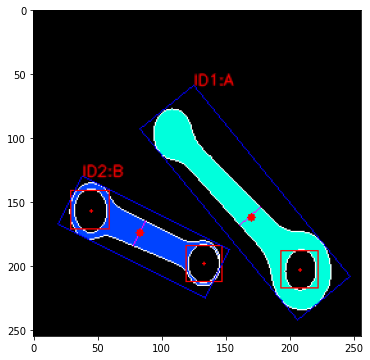

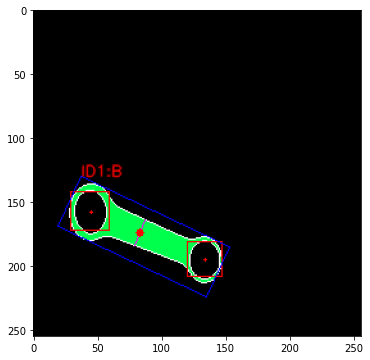

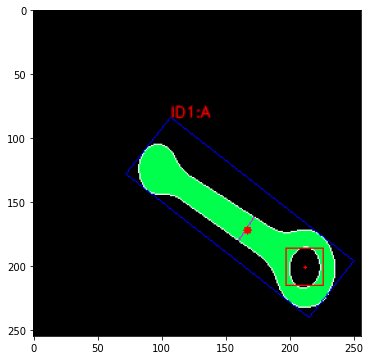

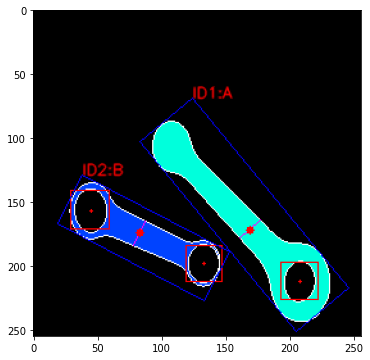

In [29]:
plot_images(image_distractors, size=15)

for i in range(len(binarized_image_distractors)):
  print("Image Number ", i+1)
  print_image_info(binarized_image_distractors[i])

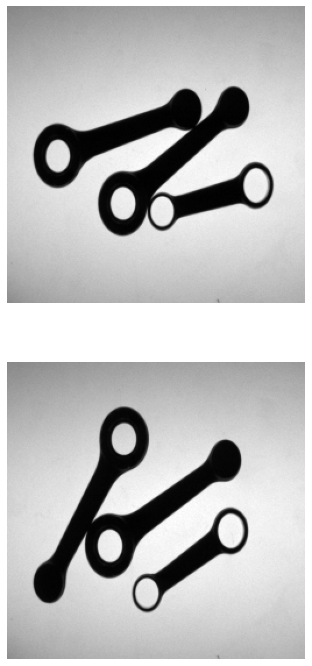

Image Number  1
----- Instance: 1 -----
type:  A
Width:  48.08
Height:  164.76
Angle:  45
Width at barycenter:  19
Perimeter:  404.46
Area:  4179.5
Holes: 
	Center:  (99, 169)
	Diameter:  27.0

----- Instance: 2 -----
type:  A
Width:  52.44
Height:  152.7
Angle:  24
Width at barycenter:  21
Perimeter:  393.5
Area:  4174.0
Holes: 
	Center:  (43, 129)
	Diameter:  26.5

----- Instance: 3 -----
type:  B
Width:  38.3
Height:  111.63
Angle:  17
Width at barycenter:  20
Perimeter:  290.94
Area:  2583.0
Holes: 
	Center:  (133, 176)
	Diameter:  25.0

	Center:  (214, 154)
	Diameter:  28.0

-----------------------
Image Number  2
----- Instance: 1 -----
type:  A
Width:  44.32
Height:  182.16
Angle:  65
Width at barycenter:  18
Perimeter:  435.1
Area:  4175.0
Holes: 
	Center:  (100, 66)
	Diameter:  26.5

----- Instance: 2 -----
type:  A
Width:  49.6
Height:  162.48
Angle:  40
Width at barycenter:  20
Perimeter:  402.66
Area:  4183.5
Holes: 
	Center:  (88, 158)
	Diameter:  26.5

----- Instance: 3 -

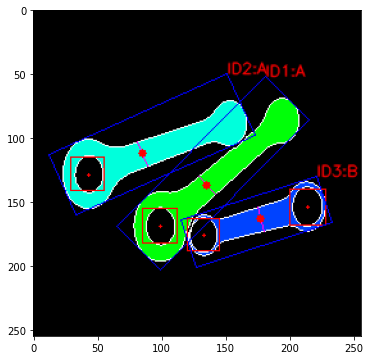

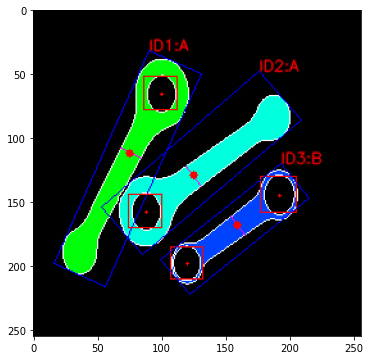

In [30]:
plot_images(image_contact, size=12)

for i in range(len(binarized_image_contact)):
  print("Image Number ", i+1)
  print_image_info(binarized_image_contact[i])

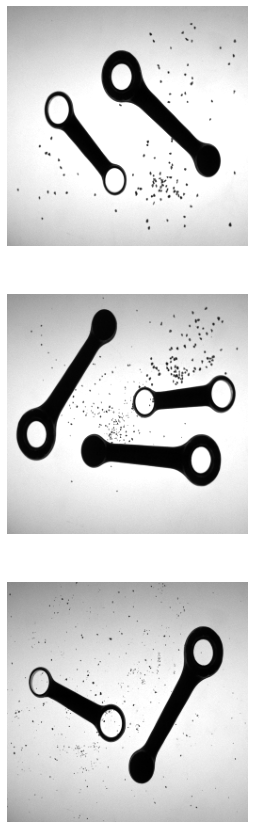

Image Number  1
----- Instance: 1 -----
type:  A
Width:  47
Height:  168
Angle:  131
Width at barycenter:  19
Perimeter:  406.11
Area:  4160.5
Holes: 
	Center:  (121, 75)
	Diameter:  26.0

----- Instance: 2 -----
type:  B
Width:  33
Height:  127
Angle:  126
Width at barycenter:  17
Perimeter:  307.75
Area:  2558.5
Holes: 
	Center:  (114, 185)
	Diameter:  25.5

	Center:  (55, 110)
	Diameter:  27.5

-----------------------
Image Number  2
----- Instance: 1 -----
type:  A
Width:  44.73
Height:  178.62
Angle:  61
Width at barycenter:  17
Perimeter:  428.66
Area:  4149.5
Holes: 
	Center:  (31, 149)
	Diameter:  26.5

----- Instance: 2 -----
type:  B
Width:  38.24
Height:  108.1
Angle:  3
Width at barycenter:  19
Perimeter:  280.07
Area:  2518.5
Holes: 
	Center:  (146, 114)
	Diameter:  25.5

	Center:  (228, 106)
	Diameter:  27.5

----- Instance: 3 -----
type:  A
Width:  53
Height:  147
Angle:  179
Width at barycenter:  21
Perimeter:  381.42
Area:  4126.0
Holes: 
	Center:  (206, 176)
	Diameter

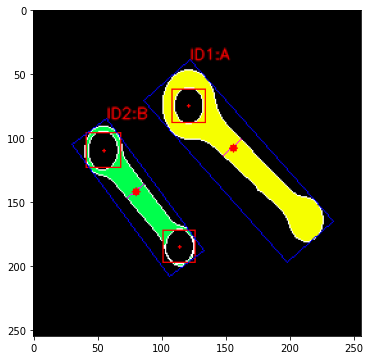

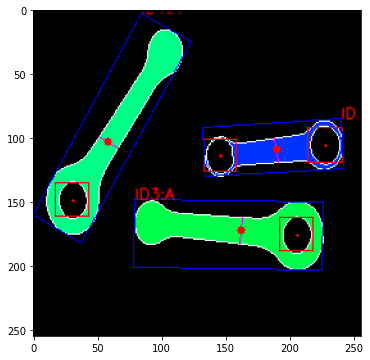

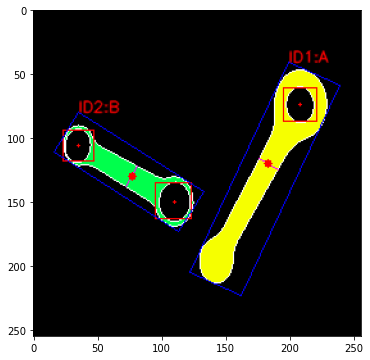

In [31]:
plot_images(image_dirty, size=15)

for i in range(len(binarized_image_dirty_gaussian)):
  print("Image Number ", i+1)
  print_image_info(binarized_image_dirty_gaussian[i])